# Rossmann Store Sales Analysis



Objectives of this project:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Let's begin by installing the required libraries.

In [1]:
#restart the kernel after installation
!pip install numpy pandas-profiling matplotlib seaborn --quiet

In [2]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

## Problem Statement


> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

## Downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to [accept the competition rules](https://www.kaggle.com/c/rossmann-store-sales/rules) before executing the following cell.

In [3]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [4]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: darshilrakeshshah
Your Kaggle Key: ··········


100%|██████████| 6.99M/6.99M [00:00<00:00, 90.8MB/s]


Extracting archive ./rossmann-store-sales/rossmann-store-sales.zip to ./rossmann-store-sales


provide your Kaggle credentials to download the data. Follow these instructions: http://bit.ly/kaggle-creds

In [5]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'test.csv', 'store.csv', 'train.csv']

Let's load the data into Pandas dataframes.

In [6]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [7]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [8]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [9]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [10]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [11]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [12]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO


### Date

First, let's convert `Date` to a `datetime` column and extract different parts of the date.

In [14]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [15]:
split_date(merged_df)
split_date(merged_test_df)

In [16]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Store Open/Closed

One observation is that sales are zero whenever the store is closed.

In [17]:
# Find the count of the stores which are closed
merged_df[merged_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [18]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [19]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [20]:
comp_months(merged_df)
comp_months(merged_test_df)

In [21]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


Let's view the results of the new columns we've created.

In [22]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
176389,2015-02-23,1000.0,2008.0,9.0,77.0
404713,2014-07-04,260.0,2006.0,10.0,93.0
559952,2014-02-15,30.0,2010.0,9.0,41.0
484420,2014-04-23,12610.0,2013.0,3.0,13.0
681241,2013-10-29,1280.0,NaN,NaN,0.0
175223,2015-02-24,980.0,2014.0,7.0,7.0
857188,2013-05-24,770.0,2013.0,5.0,0.0
697316,2013-10-14,1630.0,2009.0,9.0,49.0
772891,2013-08-08,21930.0,NaN,NaN,0.0
930488,2013-03-19,18010.0,2014.0,9.0,0.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [23]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [24]:
promo_cols(merged_df)
promo_cols(merged_test_df)

Let's view the results of the columns we've created.

In [25]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
134290,2015-04-02,1,2012.0,22.0,"Mar,Jun,Sept,Dec",34.163934,0
226513,2015-01-09,1,2014.0,18.0,"Feb,May,Aug,Nov",8.327869,0
484446,2014-04-23,0,NaN,NaN,NaN,0.000000,0
275244,2014-11-20,0,NaN,NaN,NaN,0.000000,0
120360,2015-04-15,1,2012.0,40.0,"Jan,Apr,Jul,Oct",30.491803,1
581208,2014-01-27,1,2009.0,37.0,"Jan,Apr,Jul,Oct",52.655738,1
641658,2013-12-03,1,2014.0,40.0,"Jan,Apr,Jul,Oct",0.000000,0
889379,2013-04-25,0,NaN,NaN,NaN,0.000000,0
988615,2013-01-26,0,NaN,NaN,NaN,0.000000,0
218888,2015-01-16,0,NaN,NaN,NaN,0.000000,0


The features related to competition and promotion are now much more useful.

### Input and Target Columns

Let's select the columns that we'll use for training.

In [26]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [27]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen',
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2',
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [28]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [29]:
test_inputs = merged_test_df[input_cols].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [30]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday',
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [31]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [32]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [33]:
max_distance = inputs.CompetitionDistance.max()

In [34]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [37]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [40]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [41]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [42]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions for the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model.

For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)



### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [43]:
from xgboost import XGBRegressor

In [44]:
?XGBRegressor

In [45]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

Let's train the model using `model.fit`.

In [46]:
%%time
model.fit(X, targets)

CPU times: user 5.54 s, sys: 17.4 ms, total: 5.55 s
Wall time: 2.97 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)


> <img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [47]:
preds = model.predict(X)

In [48]:
preds

array([ 7960.1133,  7581.974 ,  7993.401 , ...,  7101.1714,  8794.572 ,
       10820.442 ], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [49]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [50]:
rmse(preds, targets)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2397.1614431476673

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [51]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

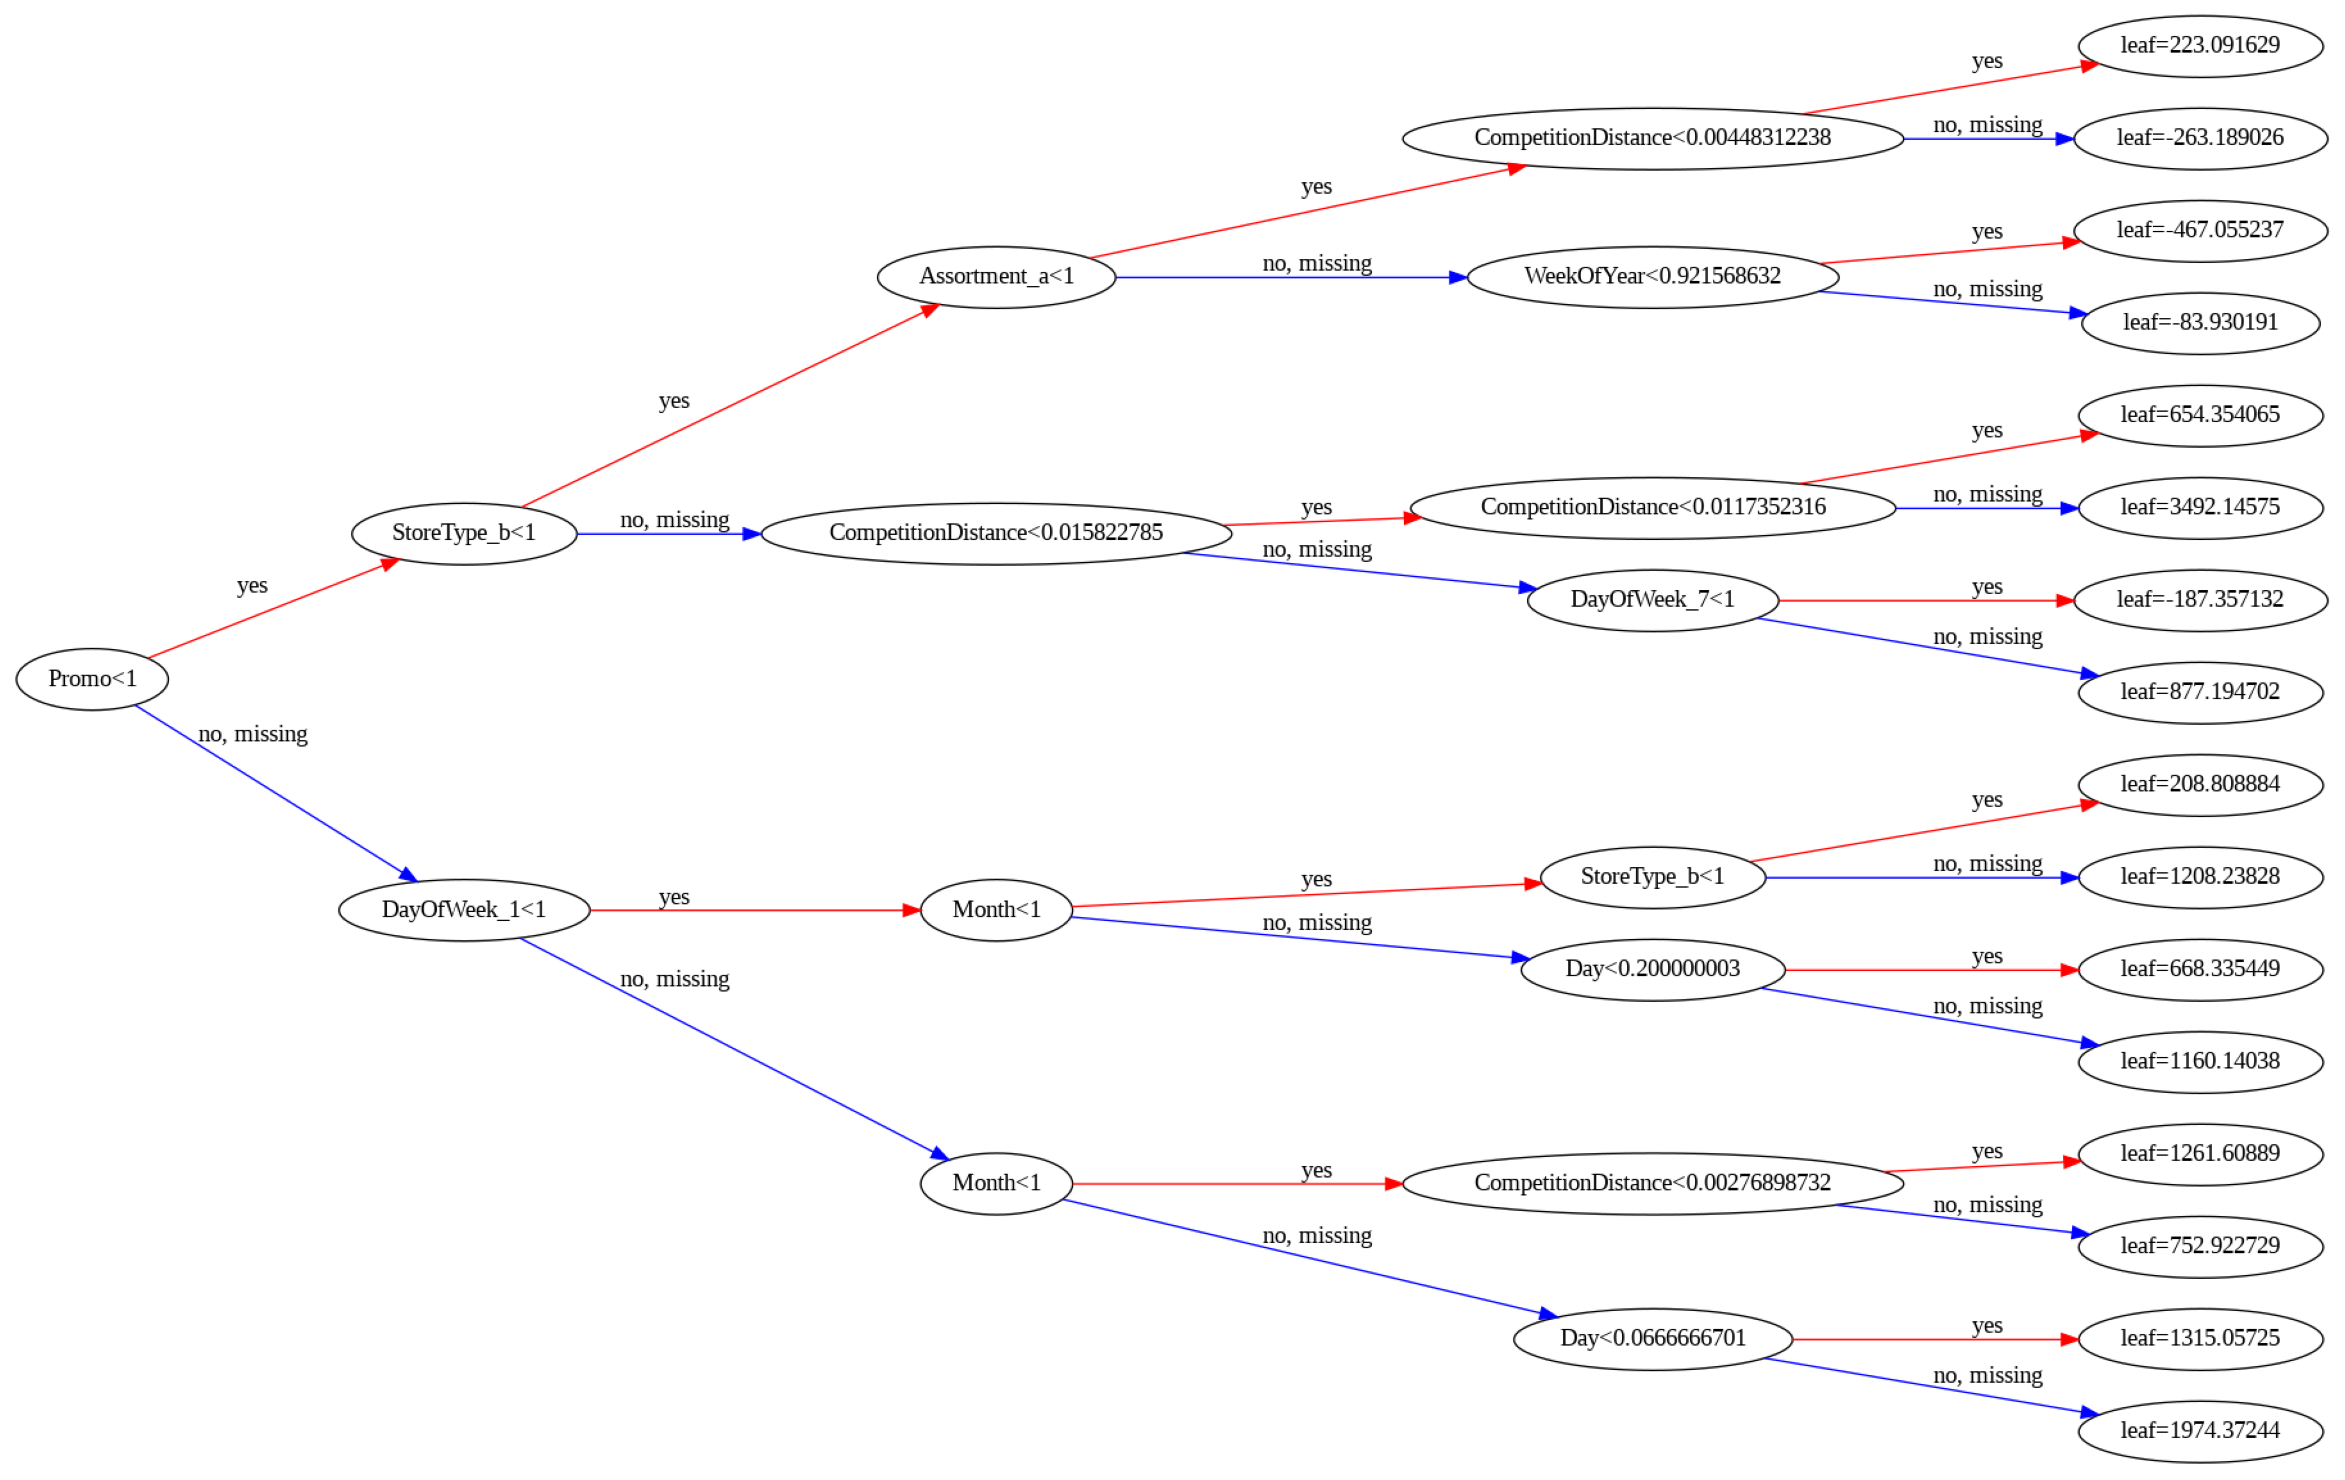

In [52]:
plot_tree(model, rankdir='LR');

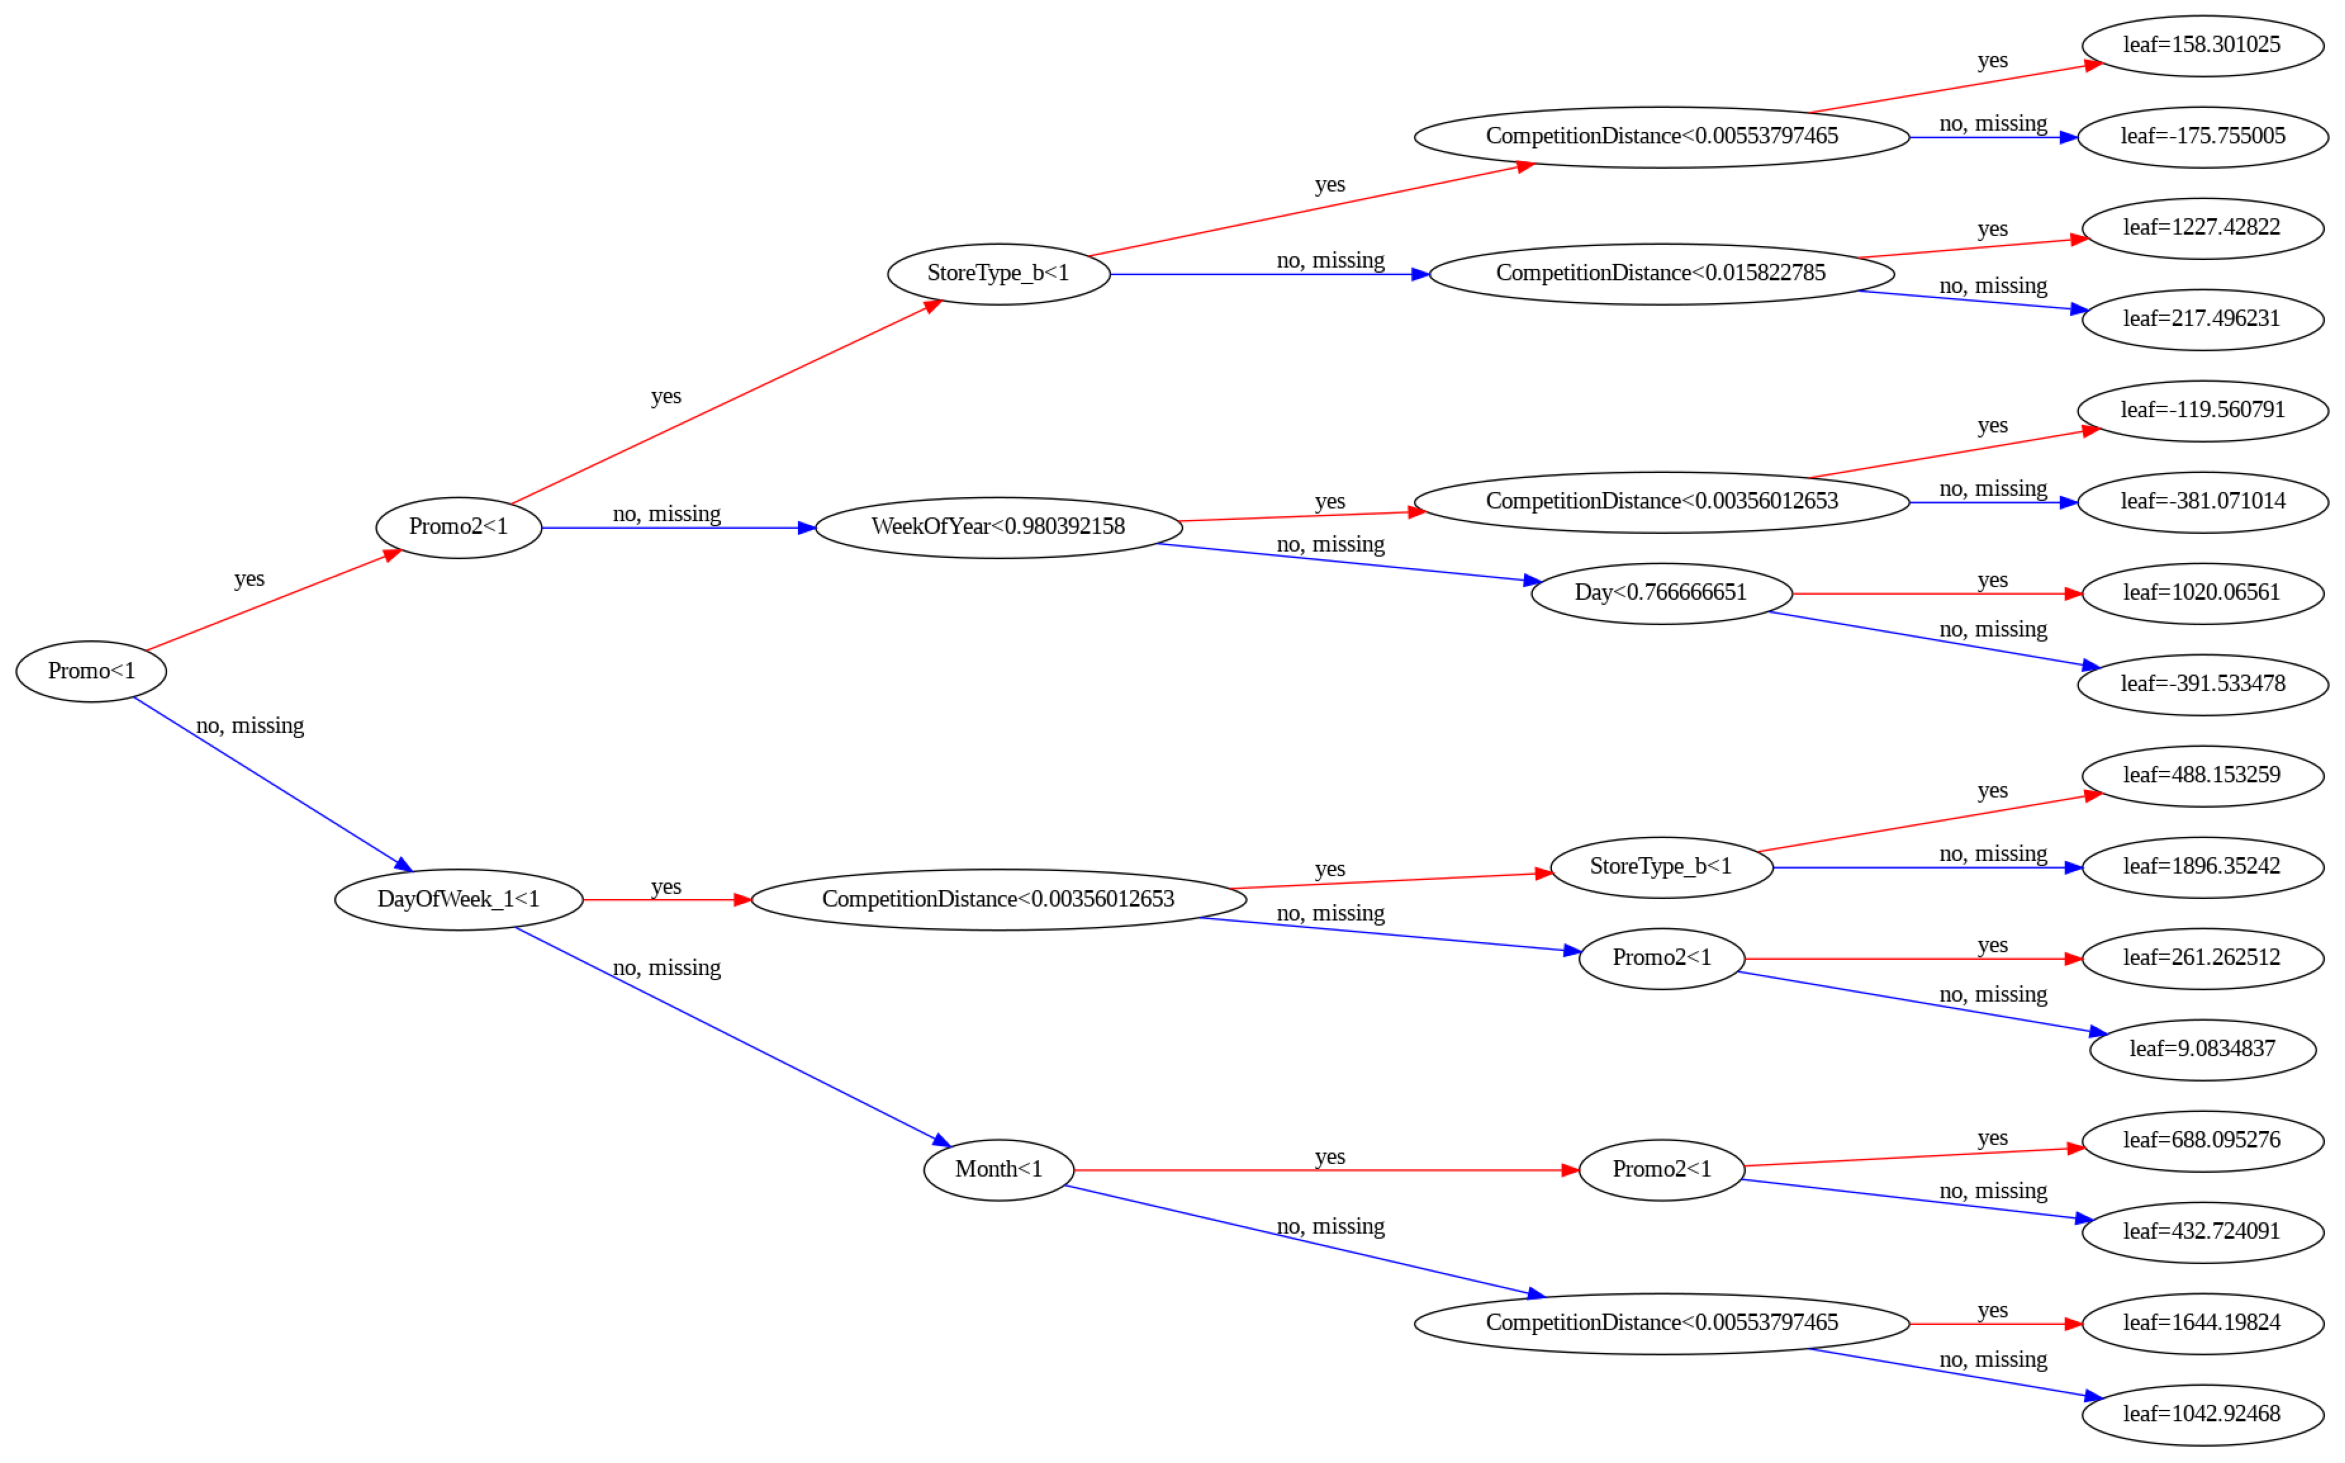

In [53]:
plot_tree(model, rankdir='LR', num_trees=1);

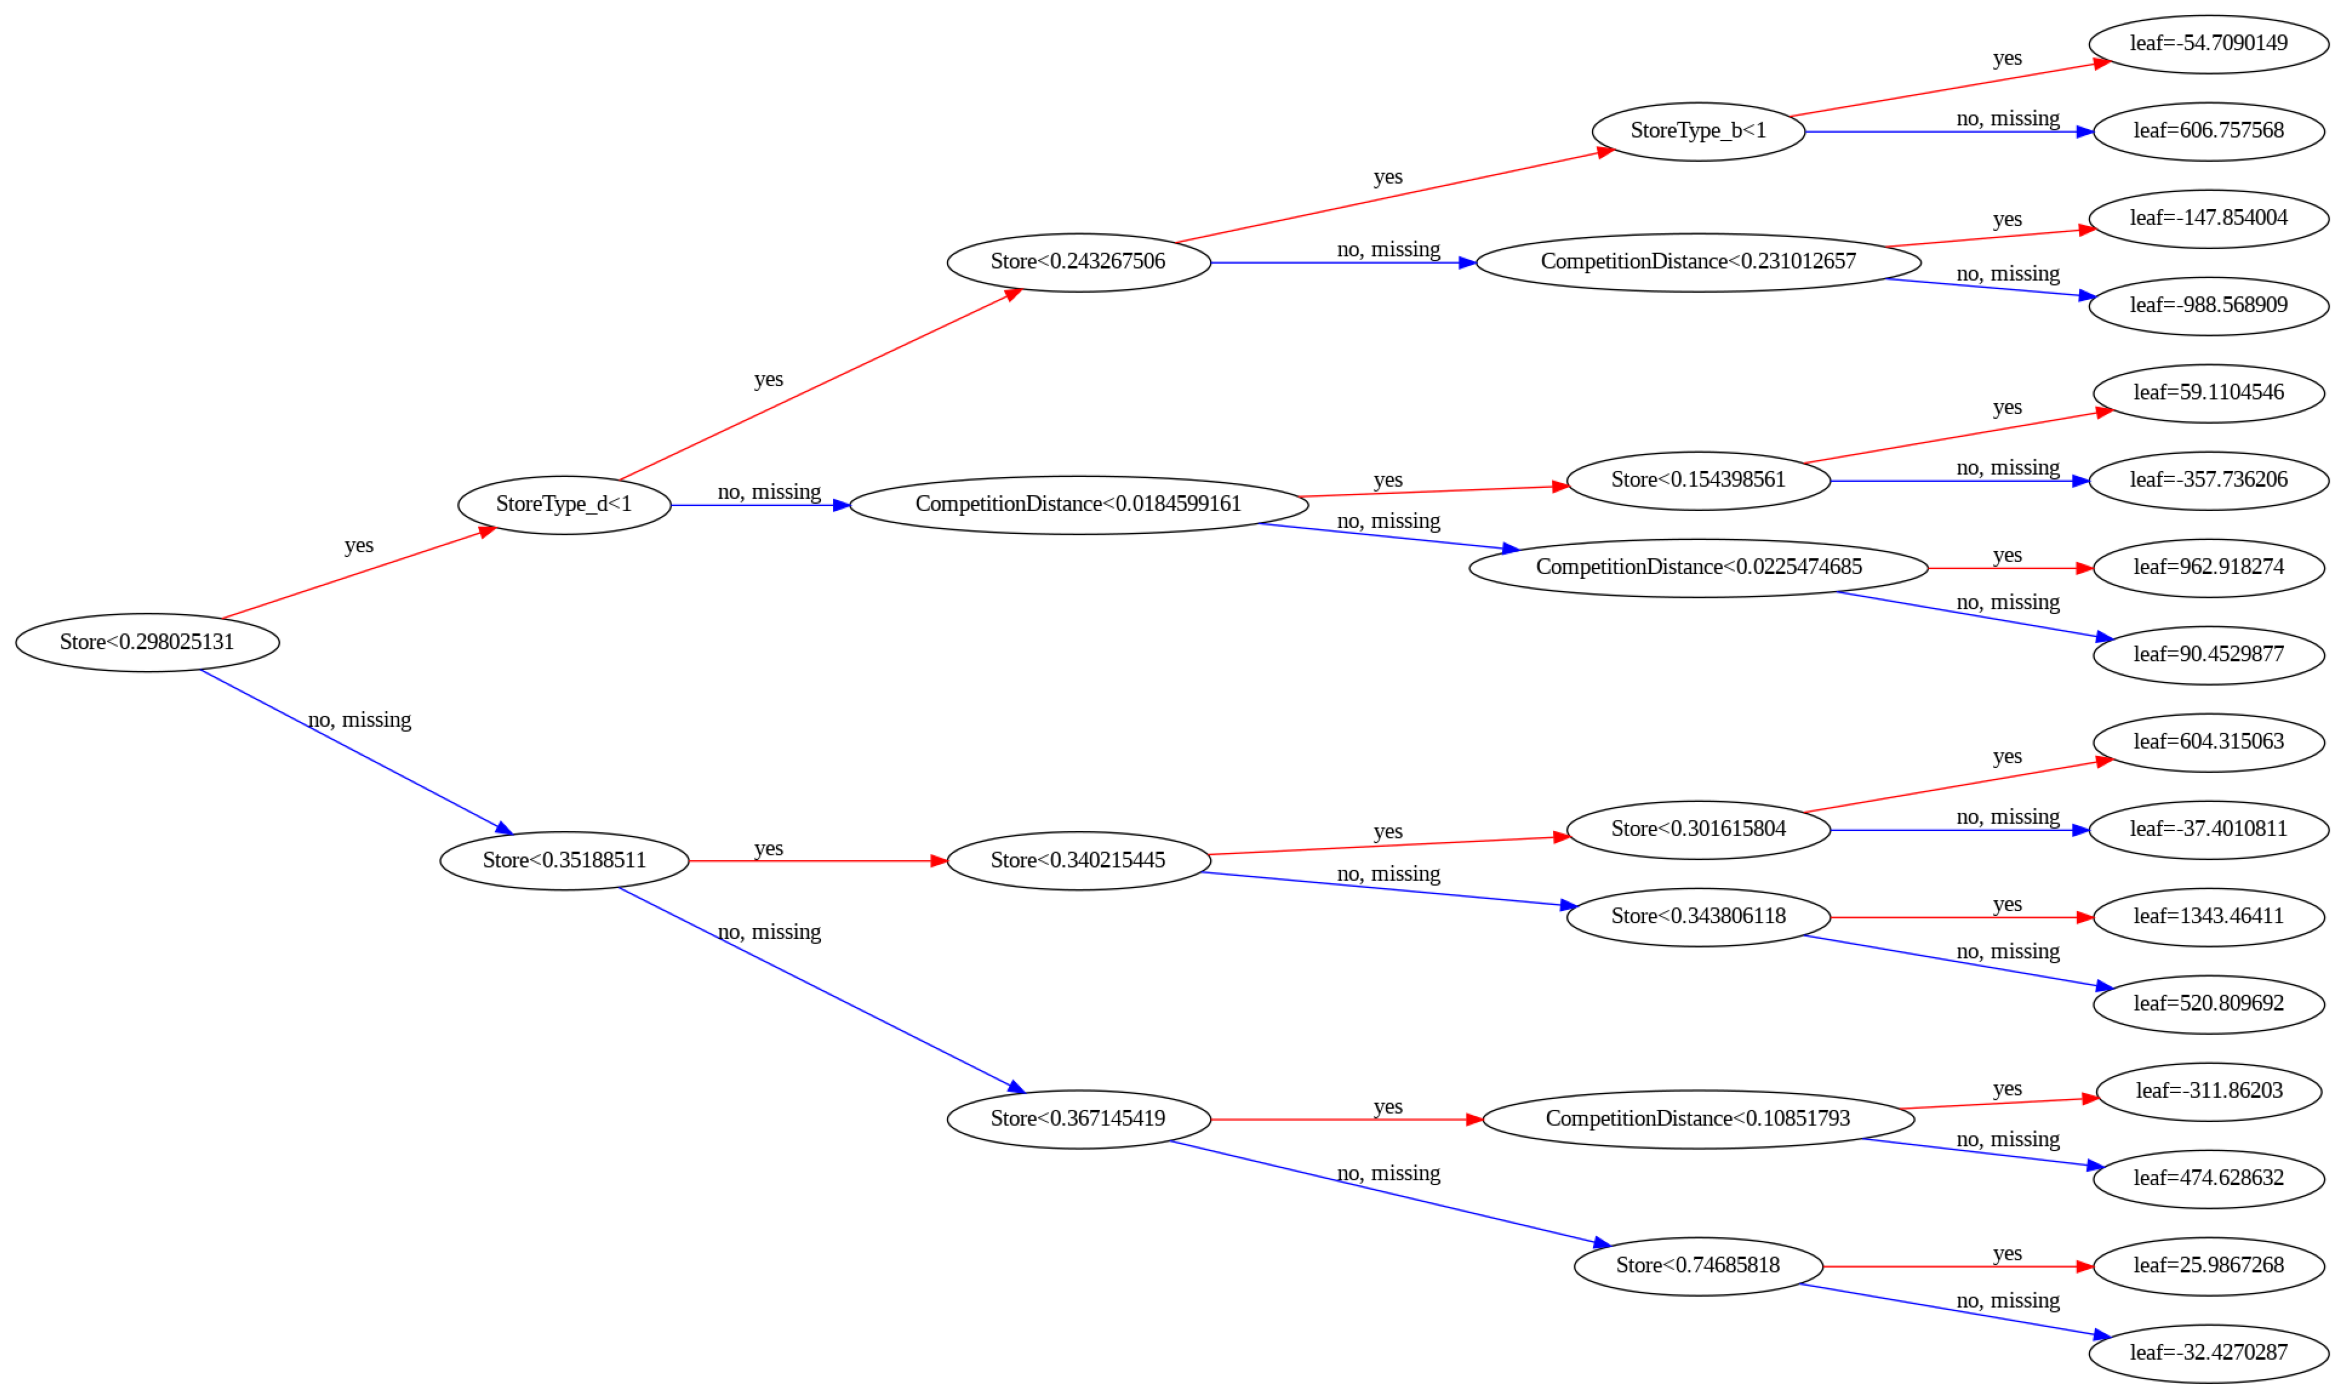

In [54]:
plot_tree(model, rankdir='LR', num_trees=19);

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [55]:
trees = model.get_booster().get_dump()

In [56]:
len(trees)

20

In [57]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.00448312238] yes=15,no=16,missing=16
				15:leaf=223.091629
				16:leaf=-263.189026
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.015822785] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.0117352316] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00276898732] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752.9

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [58]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [59]:
importance_df.head(10)

,feature,importance
1,Promo,0.334846
12,DayOfWeek_1,0.076257
24,StoreType_b,0.069301
5,Promo2,0.052821
26,StoreType_d,0.051002
9,Month,0.036114
27,Assortment_a,0.034672
11,WeekOfYear,0.034646
29,Assortment_c,0.034157
3,CompetitionDistance,0.030939


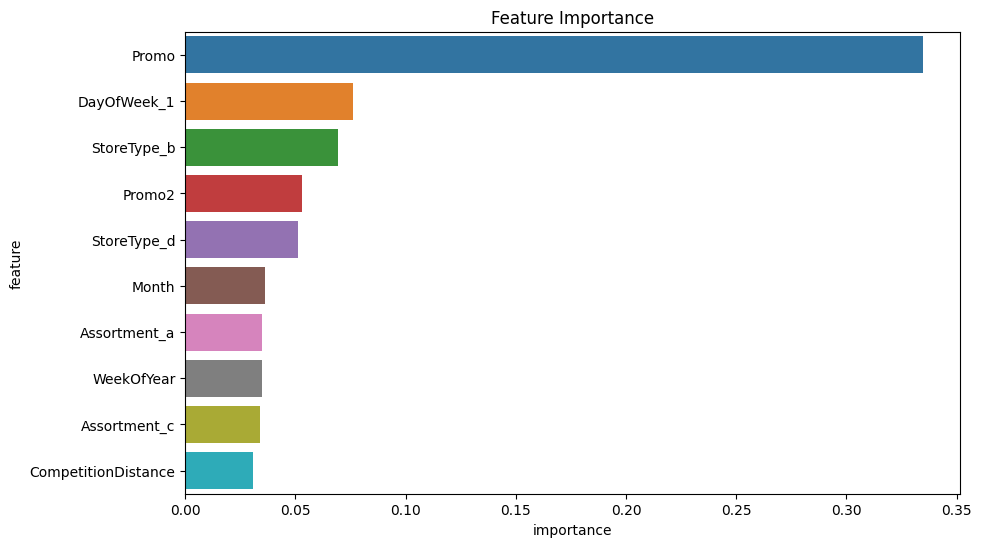

In [60]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

Scikit-learn provides utilities for performing K fold cross validation.

In [61]:
from sklearn.model_selection import KFold

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [62]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [63]:
kfold = KFold(n_splits=5)

In [66]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2394.7876402581237, Validation RMSE: 2462.850314220323


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2401.1582743064164, Validation RMSE: 2449.841681576792


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2411.8926798093644, Validation RMSE: 2391.5910868526794


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2344.831637340392, Validation RMSE: 2440.0443213469284
Train RMSE: 2391.1546155860246, Validation RMSE: 2460.8741743196815


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Let's also define a function to average predictions from the 5 different models.

In [64]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [67]:
preds = predict_avg(models, X)

In [68]:
preds

array([8031.8696, 7536.164 , 8671.131 , ..., 7181.968 , 7955.146 ,
       9629.75  ], dtype=float32)

We can now use `predict_avg` to make predictions for the test set.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [69]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [70]:
?XGBRegressor

Here's a helper function to test hyperparameters with K-fold cross validation.

In [71]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [74]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.


In [75]:
test_params(n_estimators=10)

Train RMSE: 2356.1322688272776, Validation RMSE: 2354.9691905995787


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [76]:
test_params(n_estimators=30)

Train RMSE: 1864.4284863613475, Validation RMSE: 1873.997839371633


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [77]:
test_params(n_estimators=100)

Train RMSE: 1176.9997288576285, Validation RMSE: 1200.206601116907


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [78]:
test_params(n_estimators=240)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 907.0141770430321, Validation RMSE: 939.9279063740037


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Selecting the best fit for the model
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [79]:
test_params(max_depth=2)

Train RMSE: 2383.2087982686603, Validation RMSE: 2378.5925142150227


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [80]:
test_params(max_depth=5)

Train RMSE: 1405.5350264306749, Validation RMSE: 1421.2409161731614


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [81]:
test_params(max_depth=10)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 671.3704528966698, Validation RMSE: 786.0732881256341


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [82]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 2790.0788407199866, Validation RMSE: 2781.066534800987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [83]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2178.3673837938627, Validation RMSE: 2178.981505757571


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [84]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1527.6810580736862, Validation RMSE: 1543.3595377112974


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [85]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1149.222290509384, Validation RMSE: 1173.6206315724962


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [86]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1160.0002589212274, Validation RMSE: 1185.13262912084


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [87]:
test_params(booster='gblinear')

Train RMSE: 2727.3542579177238, Validation RMSE: 2715.2090435187174


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Clearly, a linear model is not well suited for this dataset.

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters.

In [88]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000,
                     learning_rate=0.2, max_depth=10, subsample=0.9,
                     colsample_bytree=0.7)

In [89]:
%%time
model.fit(X, targets)

CPU times: user 4min 6s, sys: 1.1 s, total: 4min 7s
Wall time: 2min 27s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

Now that the model is trained, we can make predictions on the test set.

In [90]:
test_preds = model.predict(X_test)

Let's add the predictions into `submission_df`.

In [91]:
submission_df['Sales']  = test_preds

Recall, however, if if the store is not open, then the sales must be 0. Thus, wherever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `Open` in the test set. We'll replace them with 1 (open).

In [92]:
test_df.Open.isna().sum()

11

In [93]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [94]:
submission_df

,Id,Sales
0,1,4147.634277
1,2,7986.980957
2,3,8843.880859
3,4,6923.383301
4,5,7496.728027
...,...,...
41083,41084,2566.565430
41084,41085,7192.880859
41085,41086,7318.949707
41086,41087,24592.515625


We can now save the predictions as a CSV file.

In [95]:
submission_df.to_csv('submission.csv', index=None)

In [96]:
from IPython.display import FileLink

In [97]:
# Doesn't work on Colab, use the file browser instead.
FileLink('submission.csv')

/content/submission.csv

We can now make a submission on this page: https://www.kaggle.com/c/rossmann-store-sales/submit

![](https://i.imgur.com/bQ0lpSJ.png)

## Summary and References

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

The following topics were covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Check out these resources to learn more:

- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://www.kaggle.com/xwxw2929/rossmann-sales-top1
